# Ultimate Technologies Inc. Take-Home Challenge

## Part 1

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15-minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [132]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# Read in data
df = pd.read_json('logins.json')

In [76]:
# Examine dataframe
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [227]:
# Aggregate based on 15-minute time intervals
df_15min = pd.DataFrame(df.resample('15min', on='login_time').login_time.count()).rename(columns={'login_time':'num_logins'}).reset_index()
# Add columns for month, day of month, day name, and day of week
df_15min['month'] = df_15min['login_time'].dt.month
df_15min['day'] = df_15min['login_time'].dt.day
df_15min['day_name'] = df_15min['login_time'].dt.day_name()
df_15min['day_of_week'] = df_15min['login_time'].dt.dayofweek
# Make login time label only show time, not date
df_15min['login_time'] = df_15min['login_time'].dt.time
df_15min.head()

,login_time,num_logins,month,day,day_name,day_of_week
0,20:00:00,2,1,1,Thursday,3
1,20:15:00,6,1,1,Thursday,3
2,20:30:00,9,1,1,Thursday,3
3,20:45:00,7,1,1,Thursday,3
4,21:00:00,1,1,1,Thursday,3


In [162]:
# Earliest and latest login recorded
print(min(df.login_time))
print(max(df.login_time))

1970-01-01 20:12:16
1970-04-13 18:57:38


### Average Login Counts Per Time of Day

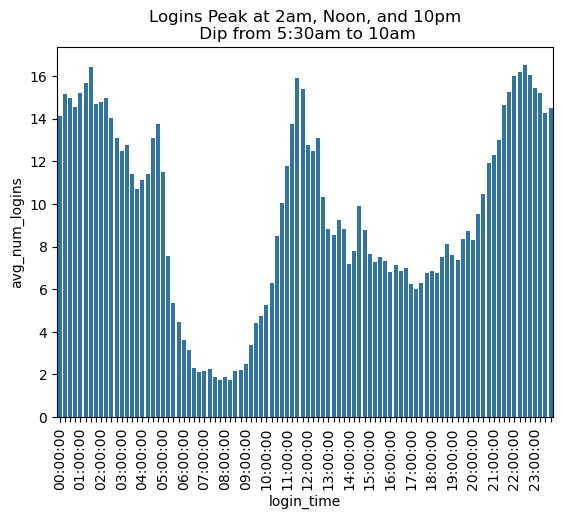

In [238]:
# Plot average number of login counts per login time
avg_logins_per_15min = round(df_15min.groupby('login_time')['num_logins'].mean(),2)
ax = sns.barplot(avg_logins_per_15min);
xticks_labels = plt.xticks()[1]
# Filter x labels to keep only every hourly label
hour_labels = [label if i % 4 == 0 else '' for i, label in enumerate(xticks_labels)]
plt.xticks(ticks=plt.xticks()[0], labels=hour_labels, rotation=90);
# Set y label and title
ax.set_ylabel('avg_num_logins');
ax.set_title('Logins Peak at 2am, Noon, and 10pm\n Dip from 5:30am to 10am');

<div class="alert alert-block alert-info">We can see some clear peaks around 2am, noon, and 10pm. The largest dip occurrs between about 5:30am and 10am, with another, less-significant, dip occurring between about 3pm and 8pm. This highlights average daily demand for rides, and provides Ultimate Technologies with insights as to when they have the greatest opportunities for customer engagement.</div>

### Average Login Counts Per Time of Day Per Day of Week

In [289]:
avg_login_by_day = pd.DataFrame(round(df_15min.groupby(['day_of_week', 'day_name',
                   'login_time'])['num_logins'].mean(),2)).rename(columns={'num_logins':'avg_num_logins'}).reset_index()

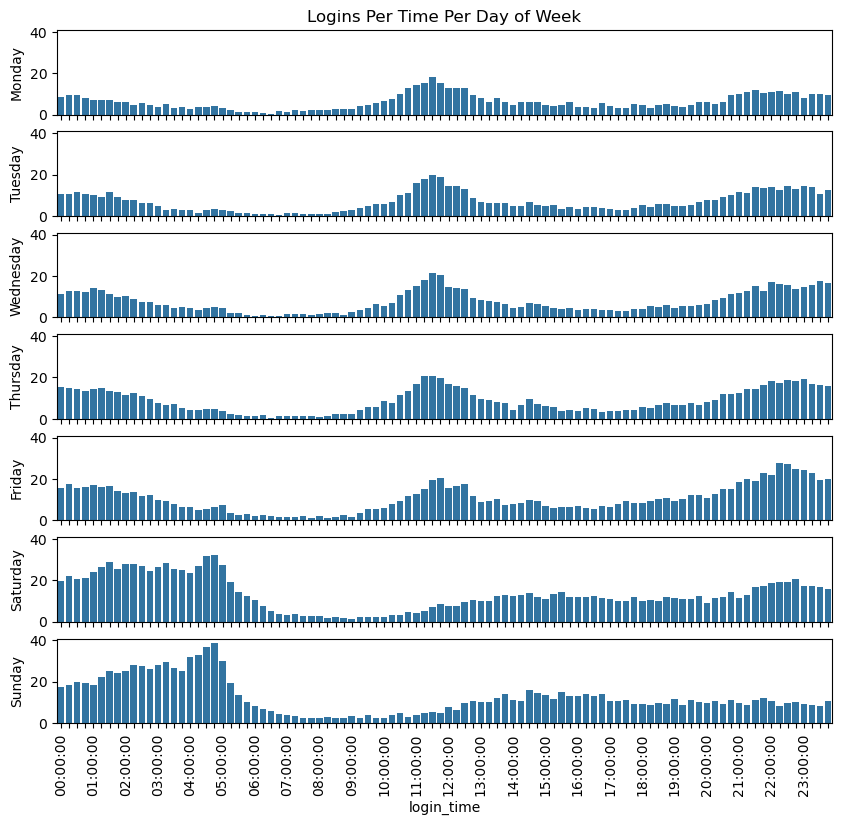

In [290]:
fig, axes = plt.subplots(nrows=7, figsize=(10,9), sharex=True, sharey=True);

for i in range(7):
    data = avg_login_by_day[avg_login_by_day['day_of_week']==i]
    ax = sns.barplot(data=data, x=data['login_time'], y=data['avg_num_logins'], ax=axes[i])
    xticks_labels = plt.xticks()[1]
    hour_labels = [label if i % 4 == 0 else '' for i, label in enumerate(xticks_labels)]
    plt.xticks(ticks=plt.xticks()[0], labels=hour_labels, rotation=90)
    axes[i].set_ylabel(data['day_name'].iloc[0])

axes[0].set_title('Logins Per Time Per Day of Week');

<div class="alert alert-block alert-info">This expands upon the analysis of demand throughout a day, by looking at how it varies by day of week. The most obvious difference between days of the week indicates that Saturday and Sunday have much higher peaks in demand between midnight and 5am, while weekdays have higher peaks in demand around noon.</div>

### Additional Summary Statistics: Total Logins Per Month and Total Logins Per Weekday

In [117]:
# Review total logins per month, drop April since it only includes 13 days of login data
logins_per_month = df_15min.groupby('month')['num_logins'].sum().drop(4)
logins_per_month

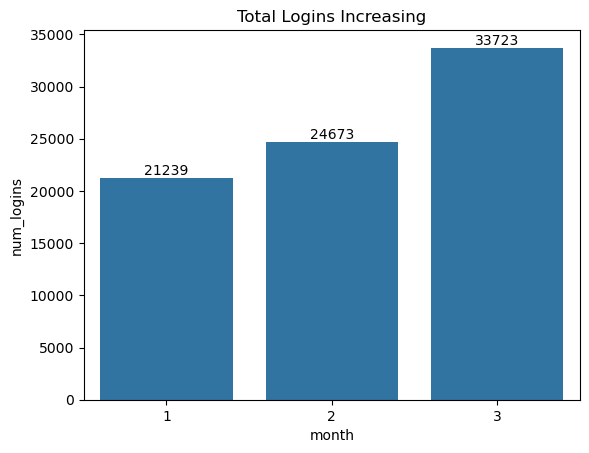

In [124]:
ax = sns.barplot(logins_per_month);
ax.bar_label(ax.containers[0]);
ax.set_title('Total Logins Increasing');

In [160]:
# Review total logins per day of week
logins_per_day = pd.DataFrame(df_15min.groupby(['day_of_week', 'day_name'])['num_logins'].sum())
logins_per_day

,,num_logins
day_of_week,day_name,
0,Monday,8823
1,Tuesday,9268
2,Wednesday,10339
3,Thursday,11960
4,Friday,15208
5,Saturday,19377
6,Sunday,18167


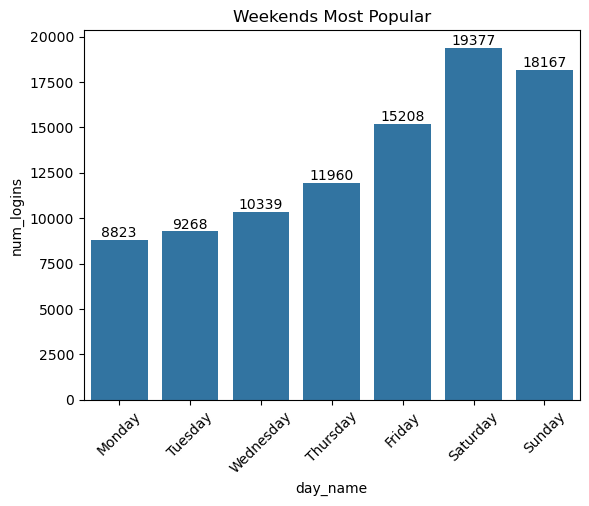

In [237]:
ax = sns.barplot(logins_per_day, x='day_name', y='num_logins');
ax.bar_label(ax.containers[0]);
plt.xticks(rotation=45);
ax.set_title('Weekends Most Popular');

## Part 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
 - How you will implement the experiment
 - What statistical test(s) you will conduct to verify the significance of the observation
 - How you would interpret the results and provide recommendations to the city operations team along with any caveats.

In [294]:
gm = pd.DataFrame({'Weekday_night':[1,0], 'Weekday_day':[0,1], 'Weekend':[1,1]}, index=['Gotham','Metropolis'])
gm

,Weekday_night,Weekday_day,Weekend
Gotham,1,0,1
Metropolis,0,1,1


As a success metric, I would examine the difference between the number of drivers available in both cities before and after the implementation. The greater the change in dual-city drivers after the implementation, the more successful the implementation.

To test the effectiveness of the proposed change, I would first calculate the average number of drivers per day that are available in both cities, before the implementation, over the span of a month. This could be computed by counting the number of unique driver clock-ins per day that also have a toll-bill that day, and taking the average count over a 30-day span. After making drivers aware of the toll-bill reimbursement, I would then calculate the average number of drivers available across both cities per day, with the implementation, over the span of a month. I would then compute the difference to determine how many more (or less) drivers were available across both cities after the implementation. 

To verify the significance of this observation, I would conduct a paired t-test with the null hypothesis (H0) that there is no difference between dual-city driver counts before and after the implementation, and the alternative hypothesis (H1) that there was a change in the number of dual-city drivers after the implementation. If the null is rejected (with a p-value < 0.05 deeming the change in dual-city drivers to be statistically signficant), and the results show an increase in dual-city drivers after the implementation, the implementation can be deemed successful.

I would express the findings to the city operations with a bar chart to simply visualize dual-city driver counts before and after the implementation. I would also analyse driver counts across days of the week to see if there are certain days that have higher numbers of dual-city drivers. This could lead to insights as to whether the reimbursement-policy is most effective on specific days of the week. In communicating these conclusions, it's important to mention other confounding factors such as seasonality or changes in traffic patterns. A longer-term study would provide greater verifiabilty of the findings.

I also would like to convey that while using dual-city driver count as a success metric indicates achievement of the the goal of having more dual-city drivers available, a caveat might come with the toll-reimbursement costs. If drivers are frequently shuttling back and forth between cities, the cost of toll reimbursement might offset net profits, even if the drive demand increases. In this case, it would be important to conduct a similar experiment, using net profit to Ultimate Technologies as a success metric, to determine if having more dual-city driver availability actually improves profit, or contrarily decreases it by accruing more expenses from the toll reimbursements.

## Part 3

Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data were pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this dataset to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data are in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

Data description
 - city: city this user signed up in
 - trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
 - signup_date: date of account registration; in the form ‘YYYYMMDD’
 - avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
 - avg_surge: The average surge multiplier over all of this user’s trips
 - last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
 - phone: primary device for this user
 - surge_pct: the percent of trips taken with surge multiplier > 1
 - ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
 - weekday_pct: the percent of the user’s trips occurring during a weekday 
 - avg_dist: the average distance in miles per trip taken in the first 30 days after signup
 - avg_rating_by_driver: the rider’s average rating over all of their trips

In [567]:
# Load libraries
from datetime import timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [532]:
# Read in data
df = pd.read_json('ultimate_data_challenge.json')

In [533]:
# Examine dataframe
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [535]:
# Impute missing values with mean for both of the 'rating' columns
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

In [536]:
# Convert 'date' columns to datetime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [537]:
# Convert 'city' and 'phone' column to numeric
dummies = pd.get_dummies(df[['city', 'phone']], prefix=['city', 'phone'], dtype='int')
df = pd.concat([df.drop(columns=['city', 'phone']), dummies], axis=1)

In [538]:
# Convert 'ultimate black user' column to integer
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

In [539]:
#Determine if user was 'active' in preceding 30 days, e.g. retained
cutoff = max(df['last_trip_date']) - timedelta(days=30)
df['Active'] = np.where(df['last_trip_date'] > cutoff, 1, 0)

In [540]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,Active
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,0,1,0,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,0,1,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,1,1,0,0


In [541]:
# Calculate % of retained users: users with 'last trip' within 30 days of last trip in entire dataframe
df[df['Active'] == 1].shape[0] / df.shape[0]

0.3662

<div class="alert alert-block alert-info">36.62% (a little over 1/3) of observed users were retained.</div>

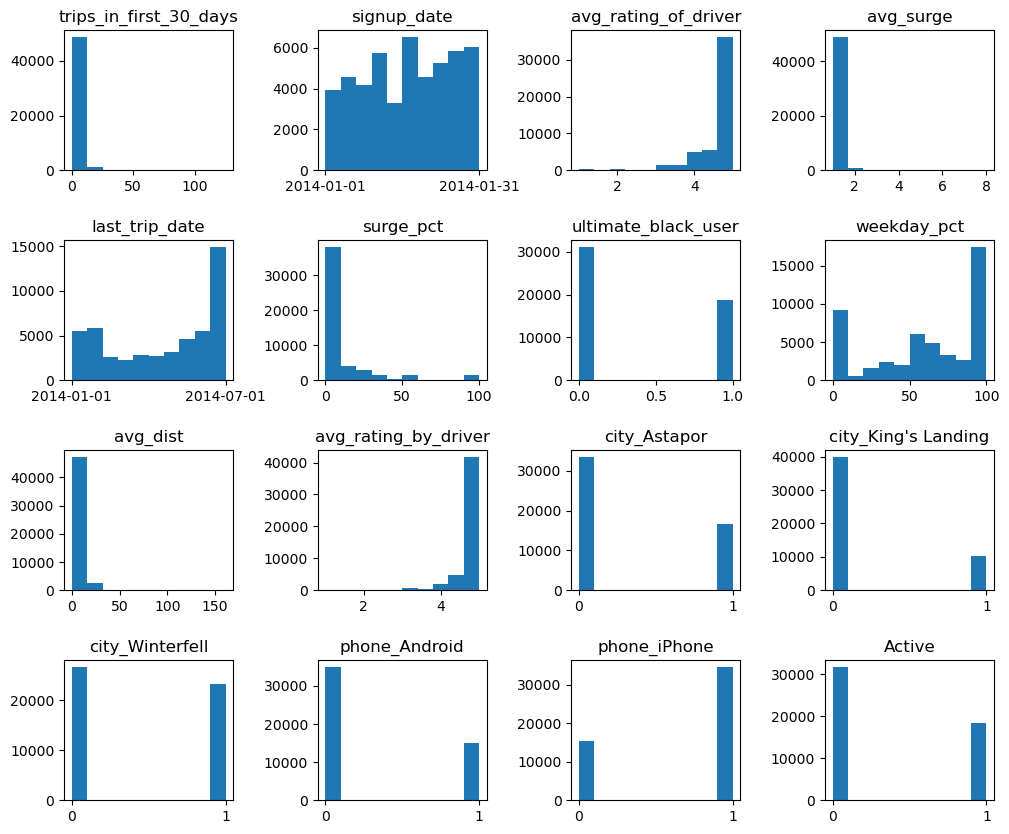

In [542]:
# Review histograms of variables
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5);

for (col, ax) in zip(df.columns, axes.flatten()):
    df[col].hist(ax=ax, grid=False)
    ax.set_title(col)
    if col in ['signup_date']:
        ax.set_xticks([min(df['signup_date']), max(df['signup_date'])])
    if col in ['last_trip_date']:
        ax.set_xticks([min(df['last_trip_date']), max(df['last_trip_date'])])
    if col in list(df.columns)[-6:]:
        ax.set_xticks([0,1])

In [572]:
# Train/test split
X = df.drop(columns=['signup_date', 'last_trip_date', 'Active'])
y = df['Active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [573]:
# Build predictive model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
train_pred = cf.predict(X_train)
test_pred = cf.predict(X_test)

In [574]:
# Accuracy score
print('Train accuracy:', accuracy_score(y_train, train_pred))
print('Test accuracy:', accuracy_score(y_test, test_pred))

Train accuracy: 0.948875
Test accuracy: 0.9506


In [588]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
print(cm)
print('\nTrue negatives:', cm[0,0])
print('False negatives:', cm[1,0])
print('True positives:', cm[1,1])
print('False positives:', cm[0,1])

[[6116  222]
 [ 272 3390]]

True negatives: 6116
False negatives: 272
True positives: 3390
False positives: 222


In [582]:
# Classification report
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6338
           1       0.94      0.93      0.93      3662

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [596]:
# Feature importance
df_fi = pd.DataFrame({'Feature': X_test.columns, 'Importance': cf.feature_importances_}).sort_values('Importance', ascending=False).reset_index(drop=True)
df_fi

,Feature,Importance
0,avg_dist,0.293702
1,weekday_pct,0.130147
2,avg_rating_by_driver,0.118125
3,avg_rating_of_driver,0.081026
4,trips_in_first_30_days,0.079402
5,surge_pct,0.078421
6,avg_surge,0.068525
7,city_King's Landing,0.046925
8,ultimate_black_user,0.032928
9,phone_iPhone,0.021491


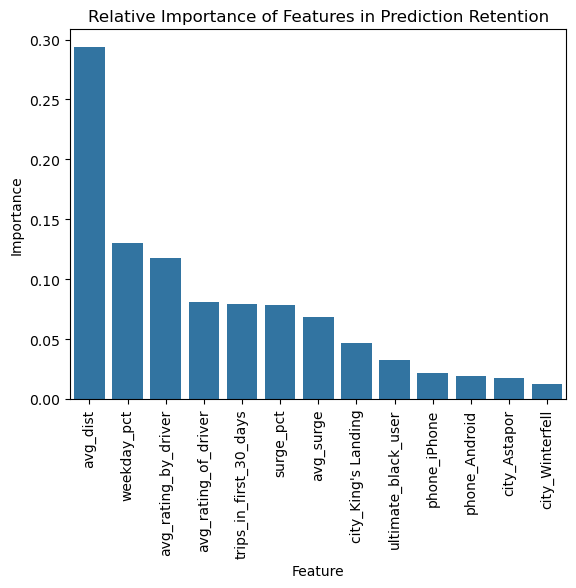

In [602]:
ax = sns.barplot(df_fi, x='Feature', y='Importance');
plt.xticks(rotation=90);
ax.set_title('Relative Importance of Features in Prediction Retention');

In [607]:
# Examine aggregate means for top 3 features
print(df.groupby('Active')[['avg_dist', 'weekday_pct', 'avg_rating_by_driver']].mean());

        avg_dist  weekday_pct  avg_rating_by_driver
Active                                             
0       6.188478    60.181597              4.786830
1       5.118977    62.214604              4.763149


### Conclusions

With only a little over 1/3 of users who signed up in January staying on the app in June, Ultimate Inc. has room to reduce its customer churn. In order to predict customer retention, I built a Random Forest Classifier with 95% accuracy on correctly predicting the test set. Morevover, precision, recall, and f1 score were all fairly high. The model had slightly higher performance for negative predictions (not retained) than positives (retained), which could be due to the imbalance of negatives / positives in the true labels, with about 2/3 of actual values being negative cases (the 2/3 of users who didn't retain). The model thus predicted slightly more false negatvies than false positives but overall was reasonably balanced. Future work could include hyperparameter tuning and other models, but the basic Random Forest Classifier worked well to get a snapshot of predicted retention and the importance of features in predicting this outcome. I chose a Random Forest Classifier as it combines various decision trees to improve accuracy and prevent overfitting in trying out feature combinations.

The most important feature in determining retention was by far the average distance per trip in the first 30 days after signup. Interstingly, retained users traveled about a mile less on average per trip in the first 30 days than users who churned. Perhaps shorter trips make return usage more attractive. Ultimate can leverage this information to promote quick inner-city travel over longer-distance treks. The second most important feature was the percent of the user’s trips occurring during a weekday. Active users have about 2% more trips per weekday. This aligns with the shorter trip preference, as perhaps shorter trips on weekdays include commutes to work, lunch, etc. Again Ultimate can build on this knowledge to frame their service as being a simple travel supplement to a daily routine, rather than a more extravagant long-distance weekend voyage. The third most important feature was average rating by driver, with an unexpected indication that riders who retained had a rating of about 0.03 less than riders who didn't retain. Does this mean that the friendlist riders are less likely to retain? Perhaps this feature needs further consideration, but understanding a general picture of what retained users look like will help Ultimate increase retention by prioritizing these aspects, such as in emphasizing shorter weekday trips over longer weekend trips.